In [2]:
import os
import cv2
import json
import random
import natsort
import matplotlib.pyplot as plt
random.seed(44)

In [2]:
json_path = os.path.expanduser("~/Desktop/joo/data/korad/data/custom/labeling/")
tiff_path = os.path.expanduser("~/Desktop/joo/data/korad/data/custom/images_plan/")
box_path = os.path.expanduser("~/Desktop/joo/data/korad/data/custom/box/")
# test_path = os.path.expanduser("~/Desktop/joo/data/korad/data/custom/test/")

numbers = os.listdir(tiff_path)
numbers.sort()

all_dict = {}

In [3]:
classes = ['AlligatorCrack', 'ConcreteCrack', 'Spalling', 'Efflorescene', 'Exposure']

colors = []
for i in range(len(classes)):
    rd1 = random.randint(0, 256)
    rd2 = random.randint(0, 256)
    rd3 = random.randint(0, 256)
    rd_color = (rd1, rd2, rd3)
    colors.append(rd_color)


labeling 이랑 image랑 file 명 맞춰서 dictionary 담기

In [4]:
all_dict = {}
folder_dict = {}

# 업체 데이터 오류 파일
with open("./korad_boxes/error_list.json", "r") as f:
    f = json.load(f)
    error =list(f.keys())

for number in numbers:
    json_root,_,json_list = next(os.walk(os.path.join(json_path+number)))
    tiff_root,_,tiff_list = next(os.walk(os.path.join(tiff_path+number)))    
    json_list.sort()
    tiff_list.sort()
    slicing_num = -5

    if number == "01":
        test_tiff_list = set(map(lambda x : x.split(".jpg")[0], tiff_list))
        test_json_list = set(map(lambda x : x.split(".json")[0], json_list))    
        result = natsort.natsorted(list(test_tiff_list - test_json_list))
        for a in error:
            result.append(a)
        
        slicing_num = -4
    temp_dict = {}

    for tiff_file in tiff_list:
        try:
            result.index(tiff_file[:slicing_num])
            all_dict[tiff_file[:slicing_num]] = [number, tiff_file, None]
            temp_dict[tiff_file[:slicing_num]] = [number, tiff_file, None]
        except ValueError:            
            all_dict[tiff_file[:slicing_num]] = [number, tiff_file, tiff_file[:slicing_num]+".json"]
            temp_dict[tiff_file[:slicing_num]] = [number, tiff_file, tiff_file[:slicing_num]+".json"]
    folder_dict[number] = temp_dict



폴더별 3900개 맞아야 함

In [5]:
# 3900 check!!
print(f"total : {len(all_dict)}")

for i in folder_dict:
    print(f"folder {i} count : {len(folder_dict[i])}")

# json 으로 만들기.
# with open("./korad_boxes/all_list.json", 'w', encoding='utf-8') as file:
#     json.dump(all_dict, file)
    
# with open("./korad_boxes/folder_list.json", 'w', encoding='utf-8') as file:
#     json.dump(folder_dict, file)

total : 23400
folder 01 count : 3900
folder 02 count : 3900
folder 03 count : 3900
folder 04 count : 3900
folder 05 count : 3900
folder 06 count : 3900


### Visualize

In [6]:
for number in folder_dict:
    json_root,_,json_list = next(os.walk(os.path.join(json_path+number)))
    tiff_root,_,tiff_list = next(os.walk(os.path.join(tiff_path+number)))    
    json_list.sort()
    tiff_list.sort()
    slicing_num = -5
    if number == "01": slicing_num = -4

    for index, file in enumerate(tiff_list):
        
        # if index == 9 : break
        
        # if file != "C01_02550.jpg" : continue
        if all_dict[file[:slicing_num]][2] == None : continue
        
        json_file = all_dict[file[:slicing_num]][2]
        
        with open(json_root+"/"+json_file, "r") as f :
            cjson = json.load(f)

        img = cv2.imread(os.path.join(tiff_root+"/"+file))
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(file)
        for box_info in cjson['labels']:
            cls = box_info['label']
            
            color_idx = classes.index(cls)
            color = colors[color_idx]
            
            box_info = box_info['boundingPoly']['vertices'][0]
            
            xmin = int(box_info['xmin'])
            xmax = int(box_info['xmax'])
            ymin = int(box_info['ymin'])
            ymax = int(box_info['ymax'])
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 3)
            img = cv2.putText(img,cls,(xmin + 5, ymin + 25),cv2.FONT_HERSHEY_SIMPLEX,1,color,3)

        # plt.figure(figsize=(20,20))
        # plt.imshow(img)
        # plt.show()
        # plt.close()
        
        cv2.imwrite(os.path.join(box_path,number+"/"+file.replace('.tiff', '.png')), img)
        

In [365]:
img = cv2.imread('/home/joo/Desktop/joo/data/korad/data/custom/test/images/C02_00001.tiff')

xmin = 1169
ymin = 0
xmax = 1412
ymax = 1440
color = (255, 0, 0)
cls = 'aaaaaa'
img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 3)
img = cv2.putText(img,cls,(xmin + 5, ymin + 25),cv2.FONT_HERSHEY_SIMPLEX,1,color,3)
cv2.imwrite('test2.jpg', img)

True

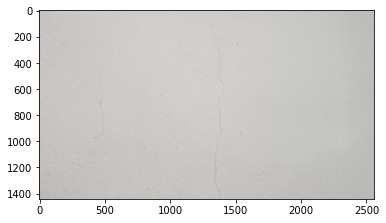

True

In [12]:
img_temp = cv2.imread('/home/joo/Desktop/joo/data/korad/data/custom/images_plan/04/C04_00174.tiff')
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
plt.imshow(img_temp)
plt.show()
plt.close()
cv2.imwrite(os.path.join('/home/joo/Downloads/C04_00175.tiff'), img_temp)